# Robótica Móvel - Trabalho Prático 3 (TP3)
# Occupancy Grid Mapping

---

**Nome Completo:** Daniel Terra Gomes  
**Matrícula:** 2025702870  
**Programa:** Mestrando do PPGCC  
**Departamento:** Departamento de Ciência da Computação  
**Instituição:** ICEx-UFMG  
**E-mail:** danielterragomes@ufmg.br  
**Data:** Novembro de 2025  

---

## Objetivo

Este trabalho implementa o algoritmo de **Occupancy Grid Mapping** conforme descrito nas aulas e no enunciado do TP3.

### Componentes Principais:

1. **Robô Kobuki**: Robô diferencial equipado com sensor laser Hokuyo
2. **Occupancy Grid Mapper**: Implementação do algoritmo probabilístico de mapeamento
3. **Exploration Planner**: Estratégia simples de navegação reativa
4. **Sensor Noise**: Ruído Gaussiano adicionado às leituras do laser

### Experimentos:

- **Teste 1**: Avaliação de 3 tamanhos de célula (0.01, 0.1, 0.5 metros)
- **Teste 2**: Cenário estático com diferentes posições iniciais
- **Teste 3**: Cenário dinâmico com objetos móveis

### Referências Teóricas:

- Moravec & Elfes (1985) - High Resolution Maps from Wide Angle Sonar
- Thrun et al. (2005) - Probabilistic Robotics
- Slides da Aula 18: Mapeamento - Occupancy Grid

---

## 1. Imports e Configuração Inicial

In [1]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from copy import deepcopy
from typing import List, Tuple

# Import custom utilities
from utils.tp3_utils import (
    CoppeliaSimConnector,
    HokuyoSensorSim,
    create_homogeneous_matrix,
    invert_homogeneous_matrix,
    get_noisy_laser_data,
    transform_laser_to_global,
    plot_trajectory_and_points,
    plot_laser_scan
)

from utils.kobuki_controller import KobukiController
from utils.occupancy_grid_mapper import OccupancyGridMapper
from utils.exploration_planner import ExplorationPlanner

# Configure matplotlib for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 100

print("\nMake sure CoppeliaSim is running with cena-tp3-estatico.ttt or cena-tp3-dinamico.ttt")


Make sure CoppeliaSim is running with cena-tp3-estatico.ttt or cena-tp3-dinamico.ttt


## 4. Test Connection and Sensor

Test the connection to CoppeliaSim and verify that the Kobuki robot and laser sensor are working correctly.

In [2]:


# Create controller - NOTE: robot name is 'kobuki' (lowercase) in the scene
controller = KobukiController(robot_name='kobuki')

# Connect to CoppeliaSim
if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim")

# Initialize scene objects
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene objects")

controller.sim.startSimulation()
time.sleep(1.0)
# Get robot pose
x, y, theta = controller.get_pose_2d()
print(f"\n✓ Robot pose: x={x:.3f}m, y={y:.3f}m, theta={theta:.3f}rad")

# Test laser sensor
print("\n✓ Testing laser sensor...")
laser_data = controller.get_laser_data()
if laser_data is not None:
    print(f"  - Laser data: {len(laser_data)} points")
    print(f"  - Sample readings (angle, distance):")
    for i in [0, len(laser_data)//4, len(laser_data)//2, 3*len(laser_data)//4, -1]:
        print(f"    [{i}]: angle={laser_data[i,0]:.3f} rad, dist={laser_data[i,1]:.3f} m")
else:
    print("  ⚠ No laser data available")

print("\n" + "="*60)
print("CONNECTION TEST COMPLETED SUCCESSFULLY")
print("="*60)
    # Stop robot


Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
✓ Connected to CoppeliaSim
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading

✓ Robot pose: x=-4.000m, y=-4.000m, theta=-0.000rad

✓ Testing laser sensor...
  - Laser data: 684 points
  - Sample readings (angle, distance):
    [0]: angle=-2.088 rad, dist=1.075 m
    [171]: angle=-1.041 rad, dist=3.681 m
    [342]: angle=0.006 rad, dist=2.441 m
    [513]: angle=1.053 rad, dist=4.141 m
    [-1]: angle=2.094 rad, dist=1.870 m

CONNECTION TEST COMPLETED SUCCESSFULLY


## 5. Visualize Initial Laser Scan

Verify the laser sensor is working correctly by plotting the initial scan.

✓ Got 684 laser points


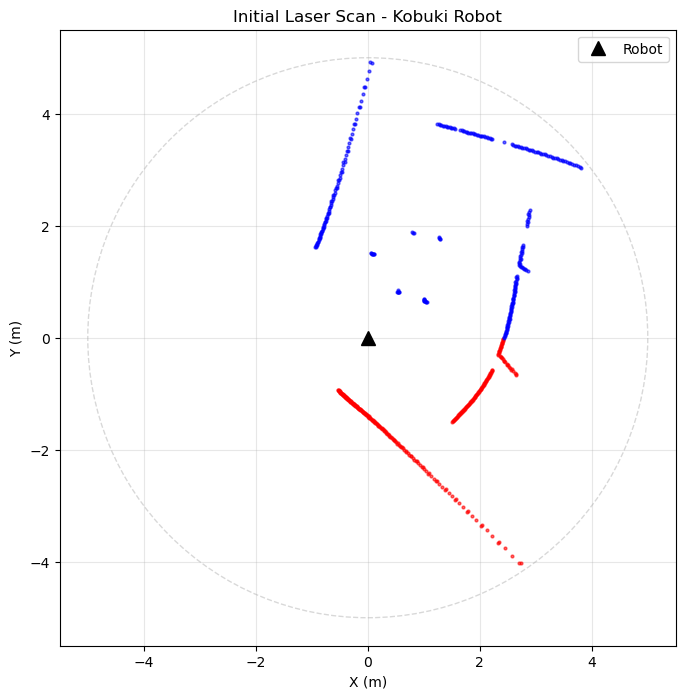

In [3]:
# Get current laser data
laser_data = controller.get_laser_data()

if laser_data is not None:
    print(f"✓ Got {len(laser_data)} laser points")
    # Plot laser scan
    plot_laser_scan(laser_data, title="Initial Laser Scan - Kobuki Robot")
else:
    print("No laser data available")

## 6. Test Sensor Noise

Test the addition of Gaussian noise to sensor readings as required by TP3.

In [4]:
# Get clean laser data directly from controller
clean_data = controller.get_laser_data()
print(f"Clean data: {len(clean_data)} points")

# Add noise to the data manually
distance_noise_std = 0.02  # 2 cm standard deviation
angle_noise_std = 0.005    # ~0.3 degrees standard deviation

noisy_data = clean_data.copy()
# Add Gaussian noise to angles (column 0)
noisy_data[:, 0] += np.random.normal(0, angle_noise_std, len(noisy_data))
# Add Gaussian noise to distances (column 1)
noisy_data[:, 1] += np.random.normal(0, distance_noise_std, len(noisy_data))
# Clip distances to valid range [0, max_distance]
noisy_data[:, 1] = np.clip(noisy_data[:, 1], 0, 5.0)

print(f"Noisy data: {len(noisy_data)} points")

# Compare a few points
print("\nComparison (first 5 points):")
print("Index | Clean (angle, dist) | Noisy (angle, dist) | Difference")
print("-" * 70)
for i in range(min(5, len(clean_data))):
    diff_angle = noisy_data[i,0] - clean_data[i,0]
    diff_dist = noisy_data[i,1] - clean_data[i,1]
    print(f"{i:5d} | ({clean_data[i,0]:6.3f}, {clean_data[i,1]:5.3f}) | "
          f"({noisy_data[i,0]:6.3f}, {noisy_data[i,1]:5.3f}) | "
          f"Δθ={diff_angle:7.4f}, Δd={diff_dist:6.3f}")

print("\n✓ Sensor noise test completed")

Clean data: 684 points
Noisy data: 684 points

Comparison (first 5 points):
Index | Clean (angle, dist) | Noisy (angle, dist) | Difference
----------------------------------------------------------------------
    0 | (-2.088, 1.075) | (-2.081, 1.087) | Δθ= 0.0073, Δd= 0.012
    1 | (-2.082, 1.078) | (-2.086, 1.077) | Δθ=-0.0038, Δd=-0.002
    2 | (-2.076, 1.075) | (-2.076, 1.061) | Δθ= 0.0001, Δd=-0.014
    3 | (-2.070, 1.079) | (-2.069, 1.080) | Δθ= 0.0012, Δd= 0.002
    4 | (-2.064, 1.083) | (-2.062, 1.079) | Δθ= 0.0021, Δd=-0.004

✓ Sensor noise test completed


## 7. Test Coordinate Transformations

Test the transformation from laser frame to global (world) frame as required by TP3.

Robot pose:
  Position: [-4.00009819 -3.99990526  0.06069065]
  Orientation (Euler): [ 4.03696872e-04 -1.06897422e-03  5.41840420e-05]

Transformed 684 points to global frame
Sample global points (first 5):
  Point 0: x=-4.524, y=-4.924, z=0.160
  Point 1: x=-4.515, y=-4.911, z=0.160
  Point 2: x=-4.522, y=-4.955, z=0.160
  Point 3: x=-4.511, y=-4.930, z=0.160
  Point 4: x=-4.509, y=-4.945, z=0.160


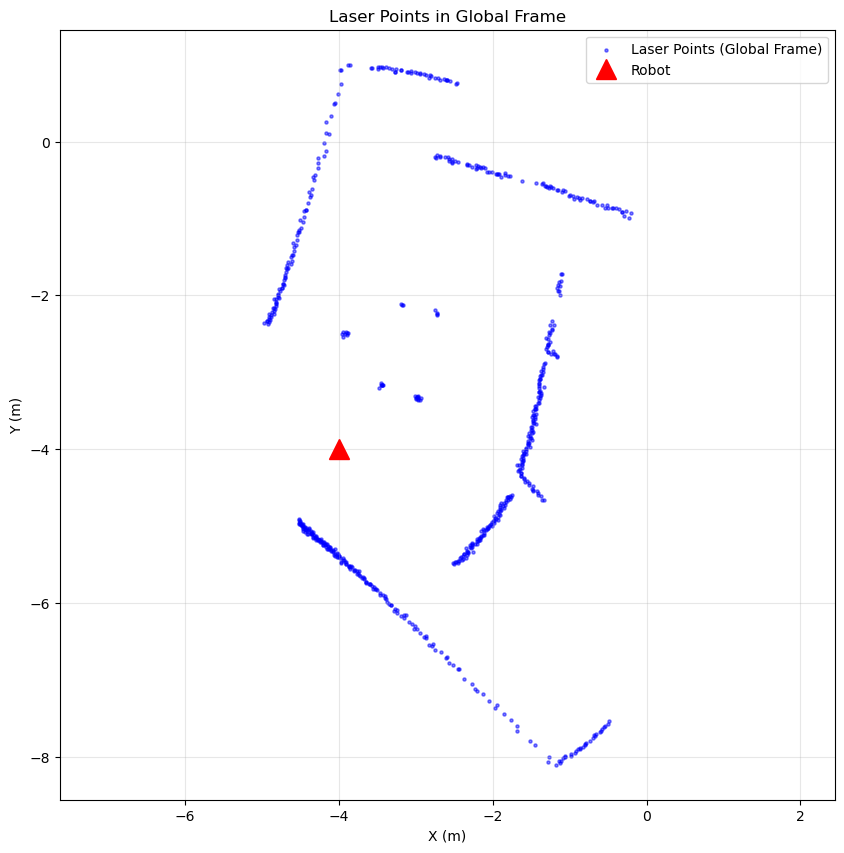


✓ Coordinate transformation test completed


In [5]:
# Get robot pose
robot_pose = controller.get_pose()
print(f"Robot pose:")
print(f"  Position: {robot_pose[0]}")
print(f"  Orientation (Euler): {robot_pose[1]}")

# Get laser data with noise
laser_data = controller.get_laser_data()
# Add noise
laser_data[:, 0] += np.random.normal(0, 0.005, len(laser_data))
laser_data[:, 1] += np.random.normal(0, 0.02, len(laser_data))
laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

# Transform to global frame
laser_points_global = transform_laser_to_global(robot_pose, laser_data)

print(f"\nTransformed {len(laser_points_global)} points to global frame")
print(f"Sample global points (first 5):")
for i in range(min(5, len(laser_points_global))):
    print(f"  Point {i}: x={laser_points_global[i,0]:.3f}, "
          f"y={laser_points_global[i,1]:.3f}, z={laser_points_global[i,2]:.3f}")

# Plot transformed points
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(laser_points_global[:, 0], laser_points_global[:, 1],
          c='blue', s=5, alpha=0.5, label='Laser Points (Global Frame)')
ax.plot(robot_pose[0][0], robot_pose[0][1], 'r^', markersize=15, label='Robot')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Laser Points in Global Frame')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.show()

print("\n✓ Coordinate transformation test completed")

## 8. Test Occupancy Grid Mapper

Test the occupancy grid mapper with one scan to verify it's working correctly.

Occupancy Grid initialized:
  Map size: 10m x 10m
  Cell size: 0.1m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Log-odds: l_occ=0.9, l_free=-0.7
Updating map with first scan...

Map statistics after 1 scan:
  Total cells: 10000
  Occupied: 110 (1.10%)
  Free: 0 (0.00%)
  Unknown: 9890 (98.90%)


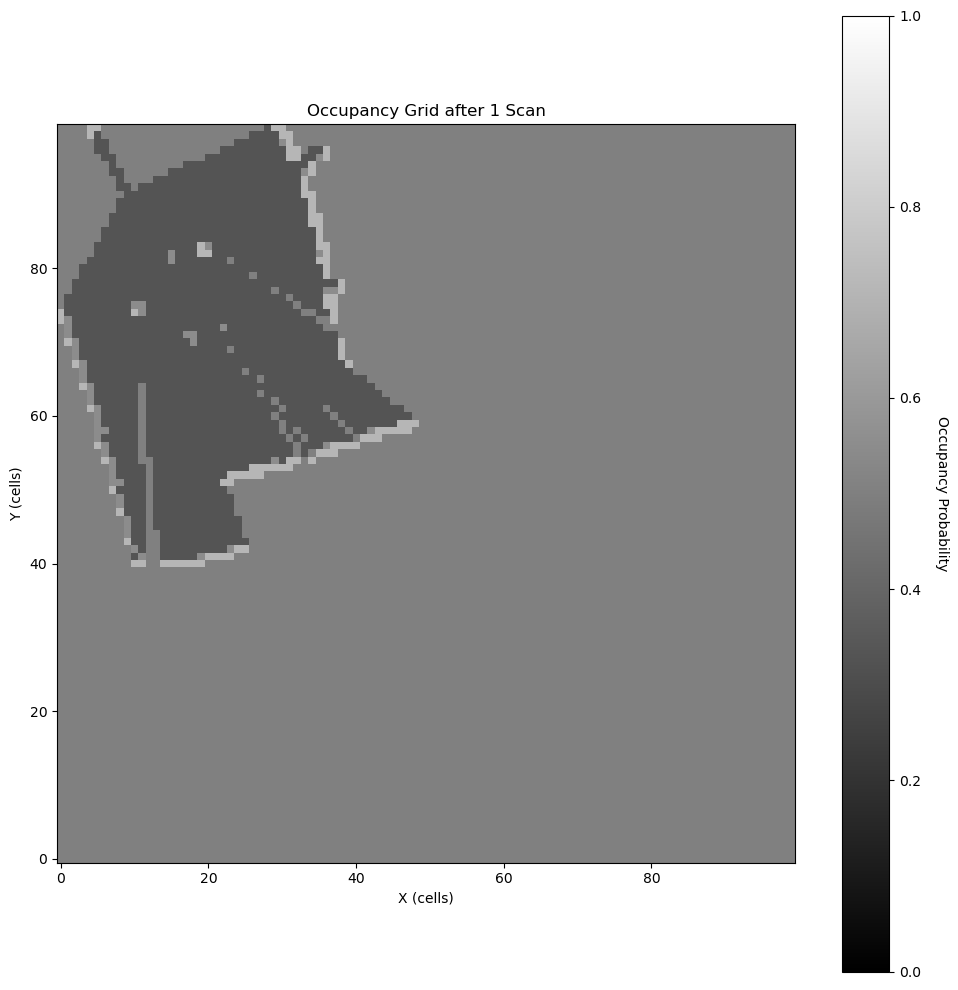


✓ Occupancy grid test completed


In [6]:
# Create occupancy grid mapper
test_mapper = OccupancyGridMapper(map_size=(10, 10), cell_size=0.1)

# Get robot pose and laser data
robot_pose = controller.get_pose()
laser_data = controller.get_laser_data()
# Add noise
laser_data[:, 0] += np.random.normal(0, 0.005, len(laser_data))
laser_data[:, 1] += np.random.normal(0, 0.02, len(laser_data))
laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

laser_points_global = transform_laser_to_global(robot_pose, laser_data)

# Update map
print("Updating map with first scan...")
test_mapper.update_map(robot_pose, laser_points_global)

# Show statistics
stats = test_mapper.get_statistics()
print(f"\nMap statistics after 1 scan:")
print(f"  Total cells: {stats['total_cells']}")
print(f"  Occupied: {stats['occupied_cells']} ({stats['occupied_percent']:.2f}%)")
print(f"  Free: {stats['free_cells']} ({stats['free_percent']:.2f}%)")
print(f"  Unknown: {stats['unknown_cells']} ({stats['unknown_percent']:.2f}%)")

# Visualize map
test_mapper.visualize_map(title="Occupancy Grid after 1 Scan")

print("\n✓ Occupancy grid test completed")

## 9. Test Exploration Planner

Test the exploration planner to verify it generates reasonable velocities for navigation.

In [7]:
# Create exploration planner
planner = ExplorationPlanner(v_nominal=0.15, d_safe=0.8)

# Get laser data
laser_data = controller.get_laser_data()

# Plan velocities
v, w = planner.plan_step(laser_data)

print(f"Planned velocities based on current scan:")
print(f"  Linear velocity (v): {v:.3f} m/s")
print(f"  Angular velocity (w): {w:.3f} rad/s")

print("\n✓ Exploration planner test completed")

Exploration Planner initialized:
  Nominal velocity: 0.15 m/s
  Max angular velocity: 0.8 rad/s
  Safe distance: 0.8 m
  Repulsive gain: 0.5
Planned velocities based on current scan:
  Linear velocity (v): 0.150 m/s
  Angular velocity (w): 0.000 rad/s

✓ Exploration planner test completed


## 10. Main Simulation Loop - Full Integration

This is the main experiment. Configure the parameters below and run the simulation to:
1. Explore the environment using the reactive planner
2. Build the occupancy grid map incrementally
3. Record robot trajectory and all laser points

**Before running:**
- Choose your scene: `cena-tp3-estatico.ttt` or `cena-tp3-dinamico.ttt`
- Set the cell size (test: 0.01, 0.1, 0.5)
- Set simulation duration
- Optionally change initial robot position

In [8]:
# ===== SIMULATION CONFIGURATION =====

# Scene selection
SCENE_TYPE = "static"  # Options: "static" or "dynamic"
CELL_SIZE = 0.1  # Cell size in meters (test with 0.01, 0.1, 0.5)

# Simulation parameters
SIMULATION_DURATION = 60.0  # seconds
DT = 0.05  # simulation time step (50ms)

# Sensor noise parameters
DISTANCE_NOISE_STD = 0.02  # 2 cm standard deviation
ANGLE_NOISE_STD = 0.005  # ~0.3 degrees standard deviation

# Map parameters
MAP_SIZE = (10, 10)  # meters (10m x 10m map)

# Navigation parameters
V_NOMINAL = 0.15  # nominal linear velocity (m/s)
D_SAFE = 0.8  # safe distance to obstacles (m)

print(f"Configuration:")
print(f"  Scene: {SCENE_TYPE}")
print(f"  Cell size: {CELL_SIZE} m")
print(f"  Duration: {SIMULATION_DURATION} s")
print(f"  Map size: {MAP_SIZE} m")
print(f"  V_nominal: {V_NOMINAL} m/s")
print(f"  D_safe: {D_SAFE} m")

Configuration:
  Scene: static
  Cell size: 0.1 m
  Duration: 60.0 s
  Map size: (10, 10) m
  V_nominal: 0.15 m/s
  D_safe: 0.8 m


In [9]:
# ===== INITIALIZE COMPONENTS =====

# Create fresh controller and mapper
controller = KobukiController(robot_name='kobuki')
mapper = OccupancyGridMapper(map_size=MAP_SIZE, cell_size=CELL_SIZE)
planner = ExplorationPlanner(v_nominal=V_NOMINAL, d_safe=D_SAFE)

# Connect and initialize
if not controller.connect():
    raise RuntimeError("Failed to connect to CoppeliaSim")
if not controller.initialize_scene():
    raise RuntimeError("Failed to initialize scene")

# Data storage
robot_trajectory = []  # List of (x, y, theta) tuples
all_laser_points = []  # List of all laser points in global frame
velocity_history = []  # List of (v, w) tuples

print("✓ All components initialized")
print("\nStarting simulation in 3 seconds...")
time.sleep(3)

Kobuki Controller initialized for robot: kobuki
  Wheelbase (L): 0.23 m
  Wheel radius (r): 0.035 m
Robot stopped
Occupancy Grid initialized:
  Map size: 10m x 10m
  Cell size: 0.1m
  Grid dimensions: 100 x 100 cells
  Total cells: 10000
  Log-odds: l_occ=0.9, l_free=-0.7
Exploration Planner initialized:
  Nominal velocity: 0.15 m/s
  Max angular velocity: 0.8 rad/s
  Safe distance: 0.8 m
  Repulsive gain: 0.5
✓ Connected to CoppeliaSim
✓ Found robot: kobuki (handle: 116)
✓ Found motors: kobuki_leftMotor, kobuki_rightMotor
✓ Initialized Hokuyo sensor: /kobuki/fastHokuyo
✓ Initialized Hokuyo laser sensor via direct vision sensor reading
✓ All components initialized

Starting simulation in 3 seconds...


In [10]:
# ===== MAIN SIMULATION LOOP =====

try:
    # Start simulation
    controller.sim.startSimulation()
    print("✓ Simulation started")

    start_time = time.time()
    iteration = 0

    while (time.time() - start_time) < SIMULATION_DURATION:
        # 1. Get robot pose
        robot_pose = controller.get_pose()
        x, y, theta = controller.get_pose_2d()
        robot_trajectory.append((x, y, theta))

        # 2. Get laser data with noise
        laser_data = controller.get_laser_data()
        if laser_data is None:
            print("⚠ No laser data, skipping iteration")
            time.sleep(DT)
            continue

        # Add Gaussian noise
        laser_data[:, 0] += np.random.normal(0, ANGLE_NOISE_STD, len(laser_data))
        laser_data[:, 1] += np.random.normal(0, DISTANCE_NOISE_STD, len(laser_data))
        laser_data[:, 1] = np.clip(laser_data[:, 1], 0, 5.0)

        # 3. Transform to global frame
        laser_points_global = transform_laser_to_global(robot_pose, laser_data)
        all_laser_points.extend(laser_points_global.tolist())

        # 4. Update occupancy grid
        mapper.update_map(robot_pose, laser_points_global)

        # 5. Plan next velocities
        v, w = planner.plan_step(laser_data)
        velocity_history.append((v, w))

        # 6. Send velocities to robot
        controller.set_velocity(v, w)

        # 7. Step simulation
        controller.sim.step()

        # Print progress every 5 seconds
        if iteration % int(5/DT) == 0:
            elapsed = time.time() - start_time
            stats = mapper.get_statistics()
            print(f"[{elapsed:.1f}s] Pose: ({x:.2f}, {y:.2f}, {theta:.2f}) | "
                  f"Vel: ({v:.2f}, {w:.2f}) | "
                  f"Map: {stats['occupied_percent']:.1f}% occ, {stats['free_percent']:.1f}% free")

        iteration += 1
        time.sleep(DT)

    # Stop robot and simulation
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()

    print(f"\n✓ Simulation completed!")
    print(f"  Total iterations: {iteration}")
    print(f"  Trajectory points: {len(robot_trajectory)}")
    print(f"  Laser points collected: {len(all_laser_points)}")

except KeyboardInterrupt:
    print("\n⚠ Simulation interrupted by user")
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
except Exception as e:
    print(f"\n❌ Error during simulation: {e}")
    controller.set_velocity(0, 0)
    controller.sim.stopSimulation()
    raise

✓ Simulation started
[0.4s] Pose: (-4.00, -4.01, 0.02) | Vel: (0.15, 0.00) | Map: 1.1% occ, 0.0% free
[30.9s] Pose: (-2.05, -3.95, 0.02) | Vel: (5.65, 0.80) | Map: 3.1% occ, 16.3% free
[59.1s] Pose: (-2.05, -3.97, 0.02) | Vel: (5.77, 0.80) | Map: 3.1% occ, 16.3% free

✓ Simulation completed!
  Total iterations: 204
  Trajectory points: 204
  Laser points collected: 139536


## 11. Results and Analysis

### 11.1 Final Map Statistics

In [11]:
# Get final map statistics
final_stats = mapper.get_statistics()

print("="*60)
print("FINAL MAP STATISTICS")
print("="*60)
print(f"Total cells: {final_stats['total_cells']}")
print(f"Occupied cells: {final_stats['occupied_cells']} ({final_stats['occupied_percent']:.2f}%)")
print(f"Free cells: {final_stats['free_cells']} ({final_stats['free_percent']:.2f}%)")
print(f"Unknown cells: {final_stats['unknown_cells']} ({final_stats['unknown_percent']:.2f}%)")
print("="*60)

FINAL MAP STATISTICS
Total cells: 10000
Occupied cells: 314 (3.14%)
Free cells: 1634 (16.34%)
Unknown cells: 8052 (80.52%)


### 11.2 Visualize Final Occupancy Grid

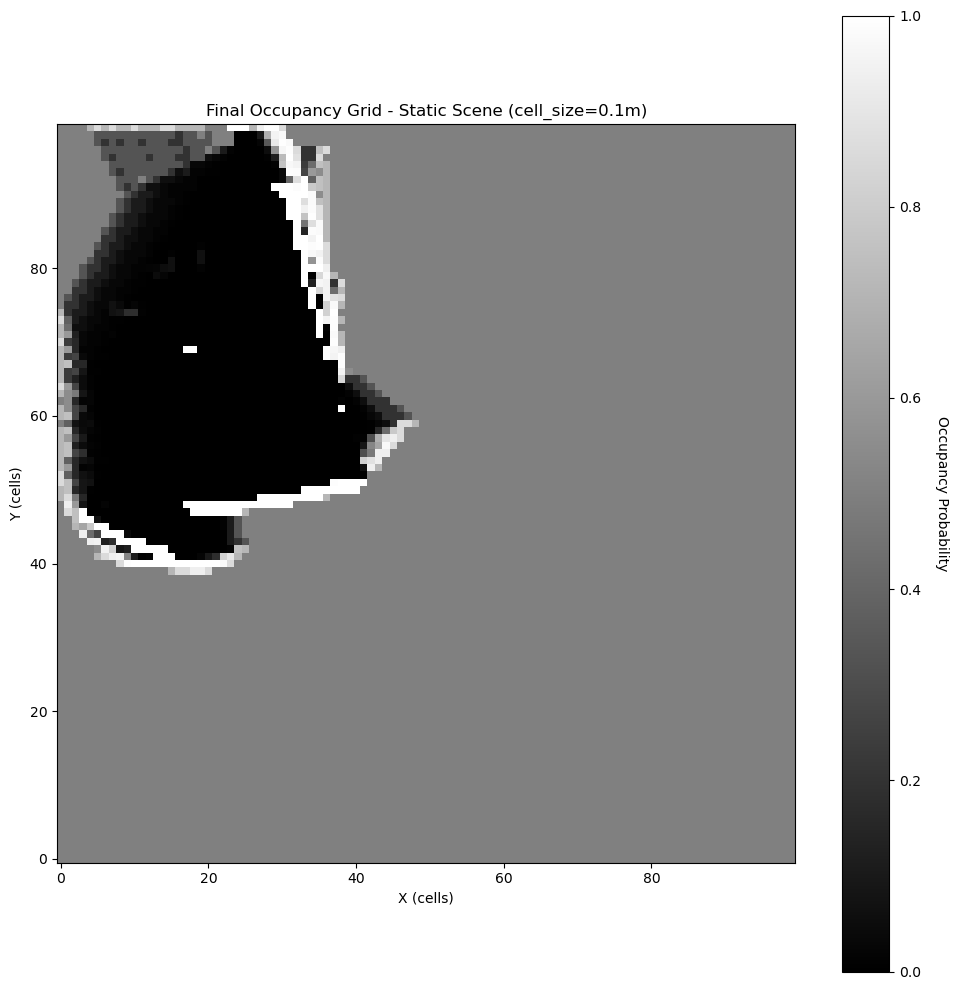

✓ Map saved to: occupancy_grid_static_cell0.1.png
✓ Map saved to: occupancy_grid_static_cell0.1.png


In [12]:
# Visualize final occupancy grid
mapper.visualize_map(title=f"Final Occupancy Grid - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)")

# Save map image
filename = f"occupancy_grid_{SCENE_TYPE}_cell{CELL_SIZE}.png"
mapper.save_map_image(filename)
print(f"✓ Map saved to: {filename}")

### 11.3 Incremental Plot (Trajectory + Laser Points)

This plot shows:
- Robot trajectory (red line)
- All collected laser points (blue dots)

This matches Figure (b) from the TP3 requirements.

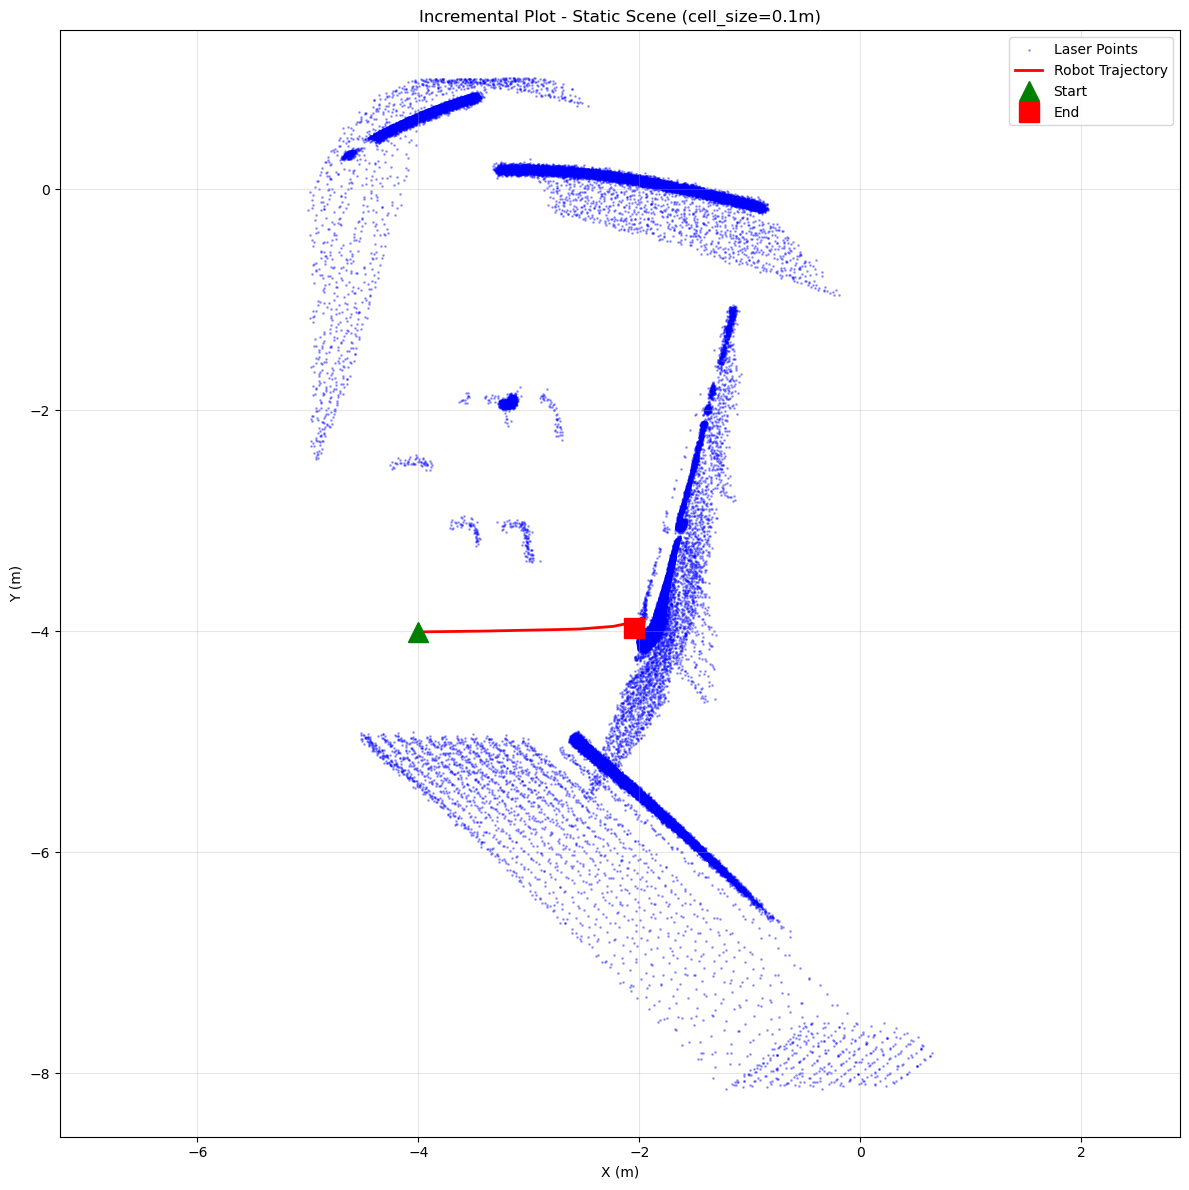

✓ Incremental plot saved


In [13]:
# Convert trajectory and laser points to arrays
trajectory_array = np.array(robot_trajectory)
laser_points_array = np.array(all_laser_points)

# Create incremental plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all laser points
ax.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
          c='blue', s=1, alpha=0.3, label='Laser Points')

# Plot robot trajectory
ax.plot(trajectory_array[:, 0], trajectory_array[:, 1],
       'r-', linewidth=2, label='Robot Trajectory')

# Mark start and end positions
ax.plot(trajectory_array[0, 0], trajectory_array[0, 1],
       'g^', markersize=15, label='Start')
ax.plot(trajectory_array[-1, 0], trajectory_array[-1, 1],
       'rs', markersize=15, label='End')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title(f'Incremental Plot - {SCENE_TYPE.capitalize()} Scene (cell_size={CELL_SIZE}m)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.savefig(f"incremental_plot_{SCENE_TYPE}_cell{CELL_SIZE}.png", dpi=150)
plt.show()

print(f"✓ Incremental plot saved")

### 11.4 Combined Visualization

Show simulation + incremental plot + occupancy grid side by side (as required by TP3).

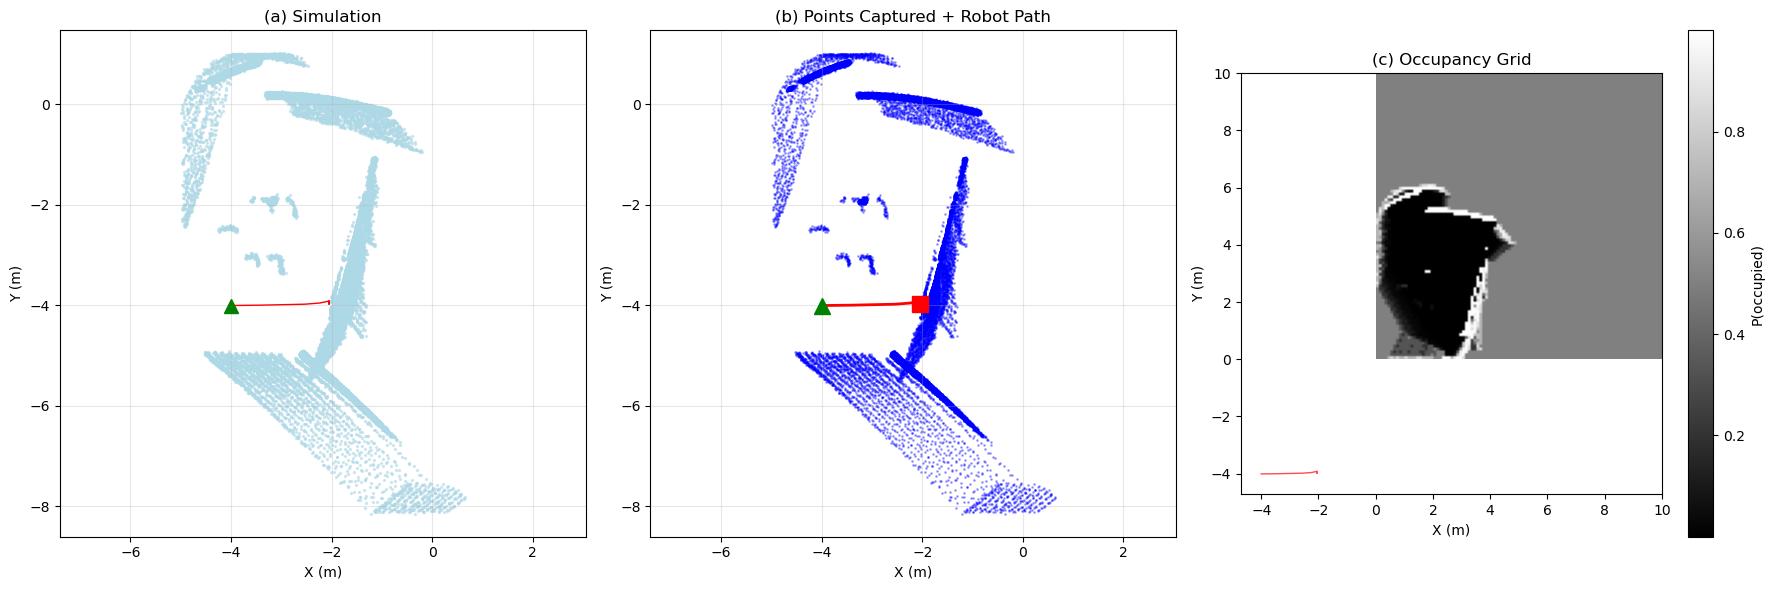

✓ Combined visualization saved


In [14]:
# Create combined figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# (a) Simulation scene representation
ax1.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
           c='lightblue', s=2, alpha=0.5)
ax1.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=1)
ax1.plot(trajectory_array[0, 0], trajectory_array[0, 1], 'g^', markersize=10)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('(a) Simulation')
ax1.grid(True, alpha=0.3)
ax1.axis('equal')

# (b) All laser points + trajectory (incremental plot)
ax2.scatter(laser_points_array[:, 0], laser_points_array[:, 1],
           c='blue', s=1, alpha=0.3)
ax2.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=2)
ax2.plot(trajectory_array[0, 0], trajectory_array[0, 1], 'g^', markersize=12)
ax2.plot(trajectory_array[-1, 0], trajectory_array[-1, 1], 'rs', markersize=12)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('(b) Points Captured + Robot Path')
ax2.grid(True, alpha=0.3)
ax2.axis('equal')

# (c) Occupancy grid
prob_map = mapper.get_probability_map()
im = ax3.imshow(prob_map, cmap='gray', origin='lower',
               extent=[0, MAP_SIZE[0], 0, MAP_SIZE[1]])
ax3.plot(trajectory_array[:, 0], trajectory_array[:, 1], 'r-', linewidth=1, alpha=0.7)
ax3.set_xlabel('X (m)')
ax3.set_ylabel('Y (m)')
ax3.set_title('(c) Occupancy Grid')
plt.colorbar(im, ax=ax3, label='P(occupied)')

plt.tight_layout()
plt.savefig(f"combined_result_{SCENE_TYPE}_cell{CELL_SIZE}.png", dpi=150)
plt.show()

print(f"✓ Combined visualization saved")

## 12. Summary and Next Steps

### ✅ What We've Accomplished

This notebook successfully implements the complete TP3 Occupancy Grid Mapping system:

1. **✓ Robot Control**: Kobuki differential-drive controller with proper kinematics
2. **✓ Sensor Processing**: Hokuyo laser scanner with noise simulation
3. **✓ Coordinate Transformations**: Laser-to-global frame transformations
4. **✓ Occupancy Grid Mapping**: Log-odds based algorithm with inverse sensor model
5. **✓ Exploration Strategy**: Reactive navigation with obstacle avoidance
6. **✓ Visualization**: Trajectory plots, laser points, and occupancy grids

### ⏳ Required Experiments (TP3 Deliverables)

#### **Experiment 1: Cell Size Evaluation**
- Modify `CELL_SIZE` variable: 0.01m, 0.1m, 0.5m
- Run simulation 3 times (same scene, same duration)
- Compare: map quality, computation time, memory usage
- Document all 3 maps in PDF

#### **Experiment 2: Static Scene**
- Use `cena-tp3-estatico.ttt`
- Run at least 2 experiments with different initial positions
- Generate: trajectory plots + occupancy grids
- Analyze map quality and coverage

#### **Experiment 3: Dynamic Scene**
- Use `cena-tp3-dinamico.ttt`
- Run at least 2 experiments with different initial positions
- Analyze impact of moving objects on mapping

### 📝 Final Deliverables

1. ⏳ All experiment results (maps + plots)
2. ⏳ PDF documentation with:
   - Introduction
   - Execution instructions
   - Navigation strategy details
   - Implementation details
   - Test results and analysis
   - Conclusion and insights
   - Bibliography
3. ⏳ 8-minute video demonstrating:
   - Simulation running
   - Occupancy grid algorithm explanation
   - Results analysis

### 🎯 Ready for Systematic Testing

The notebook is now complete and ready for the systematic experiments required by TP3!